# Rescale images based on projector greyscale transfer function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config Completer.use_jedi = False  #magic to fix autocomplete issue

### Specify measurements of screen brightness att 10 grey scale levels ranging from black (0) to white (1)

In [2]:
filename = 'HannahRig'#'ShivamRig_mean_brightness_level_6' #
postfix = 'Hannah'
measurement = np.array(np.loadtxt(open('./screenMeasurements/{}.csv'.format(filename),'rb'), delimiter=",",skiprows=1)).T
reversevals = False
if filename == 'HannahRig':
    reversevals = True

In [3]:
data = measurement.copy()
if reversevals: data[0,:] = 1-data[0,:]
if max(data[0,:]) == 10:  data[0,:] = data[0,:]/10
data[1,:] = (data[1,:]-min(data[1,:]))/ max(data[1,:])

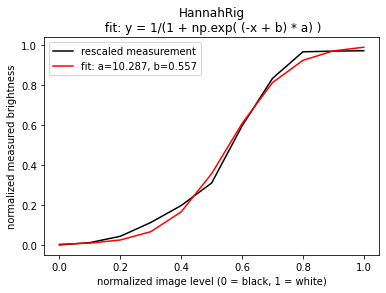

In [4]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return  1/(1 + np.exp( (-x + b) * a) )

xdata = data[0,:]
ydata = data[1,:]
popt, pcov = curve_fit(func, xdata, ydata)

fig, axs = plt.subplots(1,1, figsize=(6,4))
axs.plot(data[0,:],data[1,:], 'k', label='rescaled measurement')
axs.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))


#popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [10, 0.5]))

#plt.plot(xdata, func(xdata, *popt), 'g--',
#         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))

axs.set_xlabel('normalized image level (0 = black, 1 = white)')
axs.set_ylabel('normalized measured brightness')
axs.legend();
axs.set_title(filename + '\n fit: y = 1/(1 + np.exp( (-x + b) * a) )')
fig.savefig('./screenMeasurements/{}_fit.pdf'.format(filename))

<ipython-input-5-4abf1a2f86f1>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(x,  - ( np.log( (1-x)/x) /  popt[0]) + popt[1]  )
<ipython-input-5-4abf1a2f86f1>:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(x,  - ( np.log( (1-x)/x) /  popt[0]) + popt[1]  )


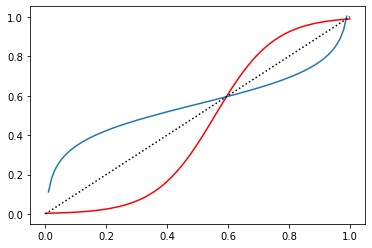

In [5]:
x = np.linspace(0,1, 100)
plt.plot(x, func(x, *popt), 'r-')
plt.plot(x,  - ( np.log( (1-x)/x) /  popt[0]) + popt[1]  )
plt.plot(x, x, 'k:')

In [7]:
from PIL import Image

savename = '13h'
path = './skyGradients/'+savename+'/'
maxBit = 255

grad_F = np.asarray(Image.open(path + 'Skybox_mean_Front_{}.png'.format(savename)))

#rescale image
grad_F_rescaled = grad_F[:,:,0]/maxBit

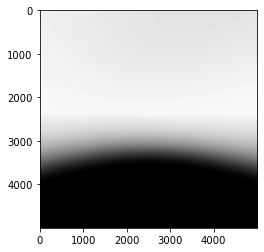

In [8]:
plt.imshow(grad_F_rescaled, cmap='gray',vmin=0,vmax=1)

In [9]:
grad_F_reshaped = grad_F_rescaled.copy()
grad_F_reshaped =  - ( np.log( (1-grad_F_rescaled)/grad_F_rescaled) /  popt[0]) + popt[1]
grad_F_reshaped[np.where(grad_F_reshaped == -np.inf)] = 0
grad_F_reshaped[np.where(grad_F_reshaped > 1)] = 1

<ipython-input-9-6daf3c5d7d8f>:2: RuntimeWarning: divide by zero encountered in true_divide
  grad_F_reshaped =  - ( np.log( (1-grad_F_rescaled)/grad_F_rescaled) /  popt[0]) + popt[1]


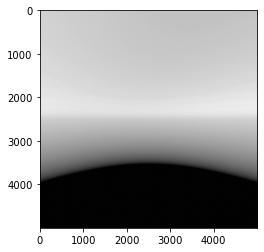

In [10]:
plt.imshow(grad_F_reshaped, cmap='gray',vmin=0,vmax=1)

(array([6681854.,  135709.,  267887.,  404469.,  668163.,  865922.,
        1219892., 1465769., 9575564., 3714771.]),
 array([0.        , 0.09377217, 0.18754434, 0.28131651, 0.37508868,
        0.46886084, 0.56263301, 0.65640518, 0.75017735, 0.84394952,
        0.93772169]),
 <BarContainer object of 10 artists>)

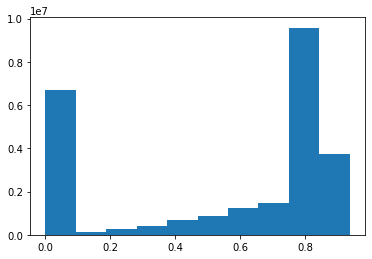

In [11]:
plt.hist(grad_F_reshaped.flatten())

(array([ 7317559.,   449738.,   390785.,   379616.,   401205.,   431404.,
          536000.,   708687.,  1094671., 13290335.]),
 array([0.        , 0.09803922, 0.19607843, 0.29411765, 0.39215686,
        0.49019608, 0.58823529, 0.68627451, 0.78431373, 0.88235294,
        0.98039216]),
 <BarContainer object of 10 artists>)

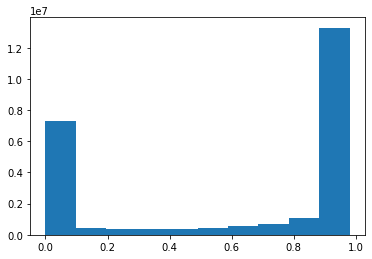

In [12]:
plt.hist(grad_F_rescaled.flatten())

### Do this for all 6 sides of the map

<ipython-input-13-7f4ef6b1936f>:14: RuntimeWarning: divide by zero encountered in true_divide
  grad_reshaped =  - ( np.log( (1-grad_rescaled)/grad_rescaled) /  popt[0]) + popt[1]
<ipython-input-13-7f4ef6b1936f>:14: RuntimeWarning: divide by zero encountered in log
  grad_reshaped =  - ( np.log( (1-grad_rescaled)/grad_rescaled) /  popt[0]) + popt[1]


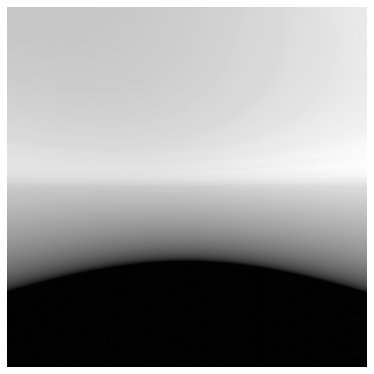

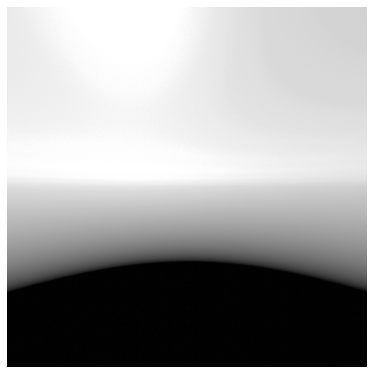

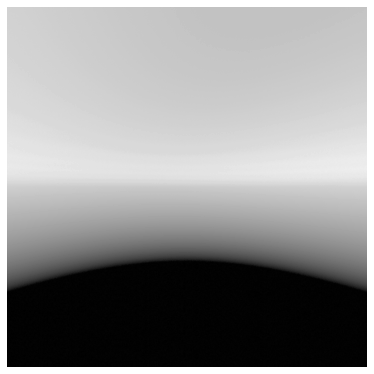

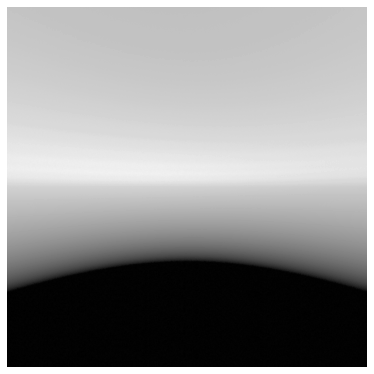

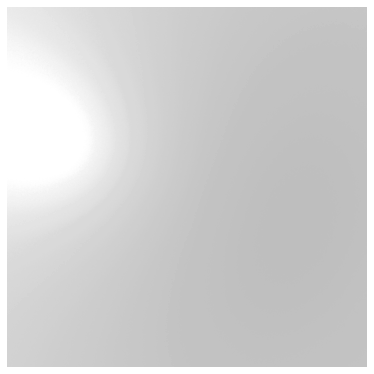

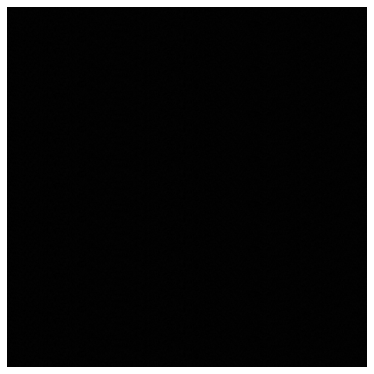

In [13]:
pt_per_cm = 150
dpiVal = 1000

maxBitSave = 2000

for side, name in enumerate(['Back','Right','Front','Left','Up','Down']):

    grad = np.asarray(Image.open(path + 'Skybox_mean_{}_{}.png'.format(name,savename)))

    #rescale image
    grad_rescaled = grad[:,:,0]/maxBit
    
    grad_reshaped = grad_rescaled.copy()
    grad_reshaped =  - ( np.log( (1-grad_rescaled)/grad_rescaled) /  popt[0]) + popt[1]
    grad_reshaped[np.where(grad_reshaped == -np.inf)] = 0
    grad_reshaped[np.where(grad_reshaped > 1)] = 1
        
    grad_reshaped = grad_reshaped*maxBitSave
    fig = plt.figure(frameon=False)
    fig.set_size_inches(5,5)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(grad_reshaped, vmin=0,vmax=maxBitSave, cmap='gray')
    fig.savefig(path+"Skybox_reshaped_{}_{}_{}.png".format(name,savename,postfix),dpi = dpiVal)